<a href="https://colab.research.google.com/github/AncoPetiteMer/case_study/blob/main/Pneumonia_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection Using Radiological Imaging

## Project Overview
This project implements a comprehensive solution for pneumonia detection from chest X-ray images using Deep Learning and knowledge transfer via pre-trained models. The processing pipeline covers the entire workflow: dataset preparation and verification, custom dataset definition, image transformations and augmentations, optimized CNN model training, precise evaluation through comprehensive metrics, and model quantization for efficient production integration. This robust and reproducible system is designed for educational and research purposes rather than real-world medical diagnosis. It should not be used for clinical decision-making. Additionally, this project is specifically designed to run within the limitations of Google Colab, utilizing TPU V2-8, ensuring that anyone can execute it freely without requiring high-end computational resources. The custom model architecture is optimized to balance performance and resource constraints, making it accessible to a wide range of users.
## Prerequisites
### Language and Environment:
- Python 3.x
- Recommended GPU environment (via Colab or a local CUDA-compatible setup)

### Libraries and Modules:
- PyTorch, Torchvision
- scikit-learn
- NumPy
- Matplotlib
- PIL (Pillow)
- kagglehub (for dataset downloading)
- Standard modules (os, shutil, zipfile, random)

## Project Structure and Organization
The project follows a well-defined organization for data and code. The radiological images should be arranged in the following directory structure:

```bash
chest_xray/
├── train/
│   ├── NORMAL/       # Normal radiological images for training
│   └── PNEUMONIA/    # Pneumonia images for training
├── test/
│   ├── NORMAL/       # Normal images for testing
│   └── PNEUMONIA/    # Pneumonia images for testing
└── val/              # Validation set (created automatically if absent)
    ├── NORMAL/
    └── PNEUMONIA/
```
The script checks for the required directories and, if necessary, downloads and extracts the dataset from a public source. This ensures a quick and secure setup, particularly for collaborative projects or deployment in evolving infrastructures.

## Technical Details and Features
### 1. Dataset Download and Verification
#### Structure Validation:
- The script scans the `chest_xray` directory to confirm the existence of `train`, `test`, and `val` folders, each containing `NORMAL` and `PNEUMONIA` subdirectories.
#### Automatic Download:
- If any directories are missing or incomplete, the script automatically downloads and extracts the dataset from a direct source.

### 2. Custom Dataset Management
#### PneumoniaDataset Class:
- A subclass of `torch.utils.data.Dataset` loads images and labels (0 for NORMAL and 1 for PNEUMONIA) while applying defined transformations.
#### Image Transformations:
- **General Transformations:** Resizing, conversion to tensors, and normalization (based on ImageNet statistics).
- **Training Augmentation:** Random effects (horizontal flip, rotation, color adjustment) to improve model generalization.

### 3. Data Preparation and Stratification
#### Stratification:
- The `create_stratified_sampled_dataset` function generates training and validation subsets while maintaining class distribution. This optimizes computation time without compromising dataset balance.

### 4. CNN Model Architecture
#### Improved Model:
The `create_improved_model` function defines an enhanced model with:
- Multiple convolutional layers with BatchNorm and LeakyReLU activation for improved stability.
- Pooling layers (MaxPool and AdaptiveAvgPool) to reduce dimensionality.
- Fully connected layers with Dropout regularization to prevent overfitting.
#### Handling Class Imbalance:
- The `calculate_class_weights` function computes class-specific weights, which are integrated into the CrossEntropyLoss function to balance class distribution.

### 5. Training and Optimization
#### Optimizer and Scheduler:
- AdamW optimizer with weight decay for effective regularization, combined with ReduceLROnPlateau scheduler to adjust the learning rate based on validation performance.
#### Advanced Techniques:
- **Mixed Precision Training:** Uses `torch.amp.GradScaler` and `torch.amp.autocast` to optimize speed and memory consumption.
- **Early Stopping:** Monitors F1-score on the validation set, saves the best model, and stops training if no improvement is detected over multiple epochs.

### 6. Evaluation and Visualization
#### Comprehensive Evaluation:
- The `evaluate_model` function computes accuracy, precision, recall, and F1-score, along with a confusion matrix and class-specific metrics.
#### Prediction Visualization:
- Using Matplotlib, the `visualize_predictions` function displays test images with their true and predicted labels, aiding qualitative performance analysis.

### 7. Model Quantization
#### Deployment Optimization:
- Dynamic quantization via `torch.quantization.quantize_dynamic` reduces model size and accelerates inference on resource-constrained environments (e.g., CPU deployment).

## How to Use the Pipeline
### Installation and Environment Setup:
- Ensure all required libraries are installed.
- Run the script in a compatible environment (Colab, GPU server, etc.).

### Script Execution:
- The script automatically checks for dataset availability and downloads it if necessary.
- Training, validation, and test datasets are prepared, followed by model training using the advanced techniques described.
- Post-training, the model is evaluated, and results (metrics and visualizations) are displayed.

### Deployment:
- Use the quantized model (`quantized_pneumonia_model.pth`) for optimized integration into production environments, ensuring fast and efficient inference.

## References

- **NeuralNine YouTube Channel:**  
  [NeuralNine on YouTube](https://www.youtube.com/c/NeuralNine)  
  This channel provides valuable tutorials and insights on building AI projects, including chatbots using PyTorch.

- **NeuralNine GitHub Repository:**  
  [NeuralNine on GitHub](https://github.com/NeuralNine)  
  Explore the repositories for sample projects and code examples that have inspired this implementation.

---

This detailed description reflects the significant improvements made to the code, ensuring a high-performance, flexible, and modular chatbot solution suitable for a broad range of applications.


A special thanks to NeuralNine for their educational content and valuable resources on AI and deep learning! 👏

In [ ]:
"""
Pneumonia Detection from Chest X-Rays using Deep Learning

This script implements a complete pipeline for detecting pneumonia from chest X-ray images using
transfer learning with a pre-trained CNN model. It handles dataset preparation, model training,
evaluation, and visualization of results.

The dataset should contain chest X-ray images organized in folders:
- chest_xray/train/NORMAL: Normal chest X-ray images for training
- chest_xray/train/PNEUMONIA: Pneumonia chest X-ray images for training
- chest_xray/test/NORMAL: Normal chest X-ray images for testing
- chest_xray/test/PNEUMONIA: Pneumonia chest X-ray images for testing
- chest_xray/val/NORMAL: Normal chest X-ray images for validation
- chest_xray/val/PNEUMONIA: Pneumonia chest X-ray images for validation

If the dataset is not found, the script will download it automatically.
"""

# Install necessary packages
!pip install kagglehub

# Import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
import kagglehub
import zipfile
import shutil
import numpy as np

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Print current directory contents
print("Files in current directory:", os.listdir())

# Set the path to the chest_xray folder
dataset_path = './chest_xray'  # Adjust if it's elsewhere

if os.path.exists(dataset_path):
    print(f"Dataset path: {dataset_path}")
    print(f"Contents of dataset path: {os.listdir(dataset_path)}")
else:
    print(f"Dataset path {dataset_path} not found")

# Check for required folders
required_folders = ['train', 'test']
missing_folders = []

if os.path.exists(dataset_path):
    missing_folders = [folder for folder in required_folders if folder not in os.listdir(dataset_path)]

if not os.path.exists(dataset_path) or missing_folders:
    """
    Download and extract the dataset if it's not found in the expected location.
    The dataset is obtained from a Mendeley Data repository containing labeled chest X-ray images.
    """
    print(f"Warning: Dataset path not found or missing required folders: {missing_folders}")
    print("Downloading the complete dataset from direct source...")

    # Download from direct source
    !wget -q https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded -O chest_xray_data.zip

    print("Extracting the dataset...")
    import zipfile
    with zipfile.ZipFile('chest_xray_data.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

    print(f"After download, contents of current directory: {os.listdir()}")
    if os.path.exists(dataset_path):
        print(f"Contents of dataset path: {os.listdir(dataset_path)}")
else:
    print("All required folders found!")


class PneumoniaDataset(Dataset):
    """
    Custom PyTorch Dataset for loading and preprocessing chest X-ray images.

    This dataset class reads chest X-ray images from the specified directory,
    applies transformations, and provides labeled data for training/evaluation.

    Attributes:
        root_dir (str): Root directory containing the image folders.
        transform (callable, optional): Optional transform to be applied to the images.
        image_paths (list): List of paths to all images in the dataset.
        labels (list): List of labels corresponding to each image (0 for NORMAL, 1 for PNEUMONIA).
    """

    def __init__(self, root_dir, transform=None):
        """
        Initialize the PneumoniaDataset.

        Args:
            root_dir (str): Directory containing 'NORMAL' and 'PNEUMONIA' subdirectories with images.
            transform (callable, optional): Optional transform to be applied to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in ['NORMAL', 'PNEUMONIA']:
            class_dir = os.path.join(root_dir, label)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpeg', '.jpg', '.png')):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(0 if label == 'NORMAL' else 1)
            else:
                print(f"Warning: Directory {class_dir} not found")

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Get a specific item from the dataset.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: (image, label) where image is a preprocessed tensor and label is 0 or 1.
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label


# Data transformation
"""
Define image transformations:
1. Resize images to 224x224 (standard input size for many CNN architectures)
2. Convert to PyTorch tensors
3. Normalize using ImageNet mean and standard deviation values
   (helps with transfer learning from ImageNet pre-trained models)
"""
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset paths
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
val_dir = os.path.join(dataset_path, 'val')

# Check if each directory exists and has the expected structure
"""
Validate the dataset structure and report statistics on the number of images
in each category (NORMAL/PNEUMONIA) for each split (train/test/val).
"""
for dir_path in [train_dir, test_dir, val_dir]:
    if os.path.exists(dir_path):
        normal_dir = os.path.join(dir_path, 'NORMAL')
        pneumonia_dir = os.path.join(dir_path, 'PNEUMONIA')

        if not os.path.exists(normal_dir) or not os.path.exists(pneumonia_dir):
            print(f"Warning: {dir_path} exists but missing NORMAL or PNEUMONIA subdirectories")
            os.makedirs(normal_dir, exist_ok=True)
            os.makedirs(pneumonia_dir, exist_ok=True)

        normal_count = len(os.listdir(normal_dir)) if os.path.exists(normal_dir) else 0
        pneumonia_count = len(os.listdir(pneumonia_dir)) if os.path.exists(pneumonia_dir) else 0
        print(f"{os.path.basename(dir_path)}: {normal_count} NORMAL images, {pneumonia_count} PNEUMONIA images")

# If validation set doesn't exist or is empty, create it from train
"""
Create a validation set by splitting off a portion of the training data if a validation set
doesn't already exist. This ensures we have a separate set of data for hyperparameter tuning
and early stopping, preventing overfitting to the test set.

The validation set is created by moving approximately 20% of the training images (up to 100)
for each class to the validation directory.
"""
if not os.path.exists(val_dir) or len(os.listdir(os.path.join(val_dir, 'NORMAL'))) == 0 or len(os.listdir(os.path.join(val_dir, 'PNEUMONIA'))) == 0:
    print("Creating or updating validation set from training data...")
    os.makedirs(os.path.join(val_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'PNEUMONIA'), exist_ok=True)

    # Move some training samples to validation
    for label in ['NORMAL', 'PNEUMONIA']:
        src_dir = os.path.join(train_dir, label)
        dest_dir = os.path.join(val_dir, label)

        if os.path.exists(src_dir) and len(os.listdir(src_dir)) > 0:
            files = os.listdir(src_dir)
            val_size = min(len(files) // 5, 100)  # 20% or max 100 images

            for file_name in files[:val_size]:
                src_file = os.path.join(src_dir, file_name)
                dest_file = os.path.join(dest_dir, file_name)
                shutil.copy(src_file, dest_file)

            print(f"Moved {val_size} {label} images to validation set")

Using device: cpu
Files in current directory: ['.config', 'sample_data']
Dataset path ./chest_xray not found
Extracting the dataset...
After download, contents of current directory: ['.config', 'chest_xray_data.zip', '__MACOSX', 'chest_xray', 'sample_data']
Contents of dataset path: ['train', '.DS_Store', 'test']
train: 1349 NORMAL images, 3884 PNEUMONIA images
test: 234 NORMAL images, 390 PNEUMONIA images
Creating or updating validation set from training data...
Moved 100 NORMAL images to validation set
Moved 100 PNEUMONIA images to validation set


In [ ]:
"""
Pneumonia Detection Model Training and Evaluation

This script implements the training pipeline for a CNN model to detect pneumonia from chest X-ray images.
It includes data preprocessing, model definition, training with mixed precision, evaluation, and
visualization of results. The script also implements techniques to handle class imbalance and
improve model performance through data augmentation and regularization.

Key features:
- Data augmentation with random flips, rotations, and color jitter
- Class imbalance handling with weighted loss
- Mixed precision training for faster computation
- Early stopping to prevent overfitting
- Model quantization for efficient deployment
- Comprehensive evaluation metrics including precision, recall, and F1 score
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import numpy as np
import random
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data augmentation and preprocessing
"""
Define separate transformations for training and testing:
- Training: Includes data augmentation (flips, rotations, color adjustments) to improve generalization
- Testing: Only includes resizing and normalization for consistent evaluation
"""
transform_train = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def create_stratified_sampled_dataset(dataset, sample_ratio=0.5):
    """
    Create a stratified subset of the dataset to reduce training time while maintaining class distributions.

    This function samples from each class according to the specified ratio, ensuring that the
    class distribution in the sampled subset matches that of the original dataset.

    Args:
        dataset (torch.utils.data.Dataset): The original dataset to sample from
        sample_ratio (float, optional): Fraction of data to sample from each class. Defaults to 0.5.

    Returns:
        torch.utils.data.Subset: A subset of the original dataset with stratified sampling
    """
    # Get the labels of the dataset
    labels = [dataset[i][1] for i in range(len(dataset))]

    # Get indices for each class
    class_indices = {c: [] for c in set(labels)}
    for i, label in enumerate(labels):
        class_indices[label].append(i)

    # Sample from each class according to the ratio
    sampled_indices = []
    for label, indices in class_indices.items():
        n_samples = int(len(indices) * sample_ratio)
        sampled_indices.extend(random.sample(indices, n_samples))

    return Subset(dataset, sampled_indices)


def create_improved_model():
    """
    Create a CNN model with improved architecture for pneumonia detection.

    This model incorporates several architectural improvements:
    - BatchNormalization layers to stabilize training
    - LeakyReLU activations to prevent dying ReLU problem
    - Dropout for regularization
    - AdaptiveAvgPooling for handling variable input sizes

    Returns:
        nn.Sequential: The constructed CNN model
    """
    model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(2),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(2),

        nn.AdaptiveAvgPool2d((7, 7)),
        nn.Flatten(),
        nn.Linear(64 * 7 * 7, 64),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.5),
        nn.Linear(64, 2)
    )
    return model


def calculate_class_weights(dataset):
    """
    Calculate class weights inversely proportional to class frequencies.

    This function computes weights for each class to handle class imbalance during training.
    Classes with fewer samples receive higher weights, causing the model to pay more attention
    to underrepresented classes.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to calculate weights from

    Returns:
        torch.Tensor: Tensor of weights for each class
    """
    # Count samples in each class
    labels = [dataset[i][1] for i in range(len(dataset))]
    class_counts = {}
    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    # Calculate weights - inverse frequency
    total = len(labels)
    num_classes = len(class_counts)
    weights = [total / (num_classes * class_counts[c]) for c in sorted(class_counts.keys())]

    return torch.tensor(weights, dtype=torch.float)


# Dataset loading (assuming train_dataset, val_dataset, and test_dataset are already defined)
"""
Load the datasets and apply appropriate transformations:
- Training data uses augmentation transforms
- Validation and test data use only normalization transforms
"""
train_dataset = PneumoniaDataset(root_dir=train_dir, transform=transform_train)
val_dataset = PneumoniaDataset(root_dir=val_dir, transform=transform_test)
test_dataset = PneumoniaDataset(root_dir=test_dir, transform=transform_test)

# Sample datasets with stratification
"""
Create stratified samples of the datasets to reduce computation time while maintaining
class distributions. This is especially important for imbalanced datasets.
"""
sampled_train_dataset = create_stratified_sampled_dataset(train_dataset, sample_ratio=0.5)  # Increased from 0.3
sampled_val_dataset = create_stratified_sampled_dataset(val_dataset, sample_ratio=0.5)

# Create dataloaders
"""
Create DataLoader objects for efficient batch processing during training and evaluation.
- Training data is shuffled to prevent the model from learning the order of samples
- Validation and test data are not shuffled to maintain consistent evaluation
"""
batch_size = 16
train_loader = DataLoader(sampled_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(sampled_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = create_improved_model().to(device)

# Calculate class weights for the loss function
"""
Calculate class weights to handle class imbalance. This gives more importance to
underrepresented classes during training.
"""
class_weights = calculate_class_weights(train_dataset)
class_weights = class_weights.to(device)

# Weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# AdamW optimizer
"""
Use AdamW optimizer which implements weight decay correctly (unlike Adam).
This helps with regularization and prevents overfitting.
"""
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

# Learning rate scheduler
"""
Implement a learning rate scheduler that reduces the learning rate when validation
performance plateaus. This helps the model converge to better minima.
"""
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True)


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, patience=3):
    """
    Train the model using mixed precision training and early stopping.

    This function implements a full training loop with several advanced techniques:
    - Mixed precision training for faster computation
    - Learning rate scheduling based on validation performance
    - Early stopping to prevent overfitting
    - Tracking of multiple evaluation metrics

    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader): DataLoader for validation data
        criterion (nn.Module): Loss function
        optimizer (torch.optim.Optimizer): Optimizer
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler
        num_epochs (int, optional): Maximum number of epochs to train for. Defaults to 15.
        patience (int, optional): Number of epochs to wait for improvement before stopping. Defaults to 3.

    Returns:
        dict: Dictionary containing training and validation metrics history
    """
    # Use updated API for mixed precision training
    scaler = torch.amp.GradScaler()

    history = {
        'train_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    best_val_f1 = 0  # Track best F1 score instead of just accuracy
    no_improve_count = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        batch_count = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Use mixed precision training with updated API
            with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            batch_count += 1

        # Calculate average loss
        epoch_loss = running_loss / max(batch_count, 1)
        history['train_loss'].append(epoch_loss)

        # Validation phase
        model.eval()

        if len(val_loader.dataset) > 0:
            all_preds = []
            all_labels = []

            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            # Calculate metrics
            val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
            precision, recall, f1, _ = precision_recall_fscore_support(
                all_labels, all_preds, average='weighted', zero_division=0
            )

            history['val_accuracy'].append(val_accuracy)
            history['val_precision'].append(precision)
            history['val_recall'].append(recall)
            history['val_f1'].append(f1)

            # Print confusion matrix
            cm = confusion_matrix(all_labels, all_preds)
            print(f"Confusion matrix:\n{cm}")

            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, "
                  f"Val Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, "
                  f"Recall: {recall:.4f}, F1: {f1:.4f}")

            # Update learning rate based on F1 score
            scheduler.step(f1)

            # Early stopping based on F1 score
            if f1 > best_val_f1:
                best_val_f1 = f1
                no_improve_count = 0
                torch.save(model.state_dict(), 'best_pneumonia_model.pth')
                print(f"Model saved with F1 score: {f1:.4f}")
            else:
                no_improve_count += 1
                if no_improve_count >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        else:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, No validation performed")

    return history


# Train the model
"""
Train the model with the specified parameters. The training process includes:
- Mixed precision training for faster computation
- Early stopping to prevent overfitting
- Learning rate scheduling based on validation F1 score
"""
num_epochs = 15  # Increased from 10
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                     num_epochs=num_epochs, patience=3)  # Increased patience


# Evaluate on test set with detailed metrics
def evaluate_model(model, test_loader):

 """
    Evaluate the model on the test dataset and report comprehensive metrics.

    This function performs a thorough evaluation of the model, calculating overall
    and class-specific metrics to provide a complete picture of model performance.

    Args:
        model (nn.Module): The trained model to evaluate
        test_loader (DataLoader): DataLoader for test data

    Returns:
        tuple: Tuple containing (accuracy, precision, recall, F1 score, confusion matrix)
    """

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    # Print confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Test confusion matrix:\n{cm}")

    print(f'Test metrics:')
    print(f'- Accuracy: {test_accuracy:.4f}')
    print(f'- Precision: {precision:.4f}')
    print(f'- Recall: {recall:.4f}')
    print(f'- F1 Score: {f1:.4f}')

    # Calculate class-specific metrics
    precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(
        all_labels, all_preds, zero_division=0
    )

    print(f"Class-specific metrics:")
    for i, (p, r, f, s) in enumerate(zip(precision_class, recall_class, f1_class, support_class)):
        print(f"Class {i}: Precision: {p:.4f}, Recall: {r:.4f}, F1: {f:.4f}, Support: {s}")

    return test_accuracy, precision, recall, f1, cm

# Load best model and evaluate
model.load_state_dict(torch.load('best_pneumonia_model.pth'))
test_metrics = evaluate_model(model, test_loader)

# Optional: Visualize test predictions
def visualize_predictions(model, test_loader, num_samples=5):
    import matplotlib.pyplot as plt

    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_so_far < num_samples:
                    images_so_far += 1
                    ax = plt.subplot(2, num_samples//2 + 1, images_so_far)
                    ax.set_title(f'Predicted: {preds[i].item()}, True: {labels[i].item()}')

                    # Denormalize the image
                    img = images[i].cpu().numpy().transpose((1, 2, 0))
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std * img + mean
                    img = np.clip(img, 0, 1)

                    ax.imshow(img)
                    ax.axis('off')

                if images_so_far >= num_samples:
                    return

    plt.tight_layout()
    plt.show()

# Uncomment to visualize predictions
visualize_predictions(model, test_loader)

# Quantize the model for efficient deployment
quantized_model = torch.quantization.quantize_dynamic(
    model.to('cpu'),
    {nn.Linear, nn.Conv2d},
    dtype=torch.qint8
)

# Save quantized model
torch.save(quantized_model.state_dict(), 'quantized_pneumonia_model.pth')

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Confusion matrix:
[[50  0]
 [ 4 46]]
Epoch 1/15, Loss: 0.3094, Val Accuracy: 0.9600, Precision: 0.9630, Recall: 0.9600, F1: 0.9599
Model saved with F1 score: 0.9599
Confusion matrix:
[[50  0]
 [ 4 46]]
Epoch 2/15, Loss: 0.2088, Val Accuracy: 0.9600, Precision: 0.9630, Recall: 0.9600, F1: 0.9599
Confusion matrix:
[[47  3]
 [ 0 50]]
Epoch 3/15, Loss: 0.1811, Val Accuracy: 0.9700, Precision: 0.9717, Recall: 0.9700, F1: 0.9700
Model saved with F1 score: 0.9700
Confusion matrix:
[[49  1]
 [ 2 48]]
Epoch 4/15, Loss: 0.1742, Val Accuracy: 0.9700, Precision: 0.9702, Recall: 0.9700, F1: 0.9700
Model saved with F1 score: 0.9700
Confusion matrix:
[[49  1]
 [ 3 47]]
Epoch 5/15, Loss: 0.1629, Val Accuracy: 0.9600, Precision: 0.9607, Recall: 0.9600, F1: 0.9600
Confusion matrix:
[[49  1]
 [ 2 48]]
Epoch 6/15, Loss: 0.1550, Val Accuracy: 0.9700, Precision: 0.9702, Recall: 0.9700, F1: 0.9700
Confusion matrix:
[[49  1]
 [ 2 48]]
Epoch 7/15, Loss: 0.1410, Val Accuracy: 0.9700, Precision: 0.9702, Recall: 

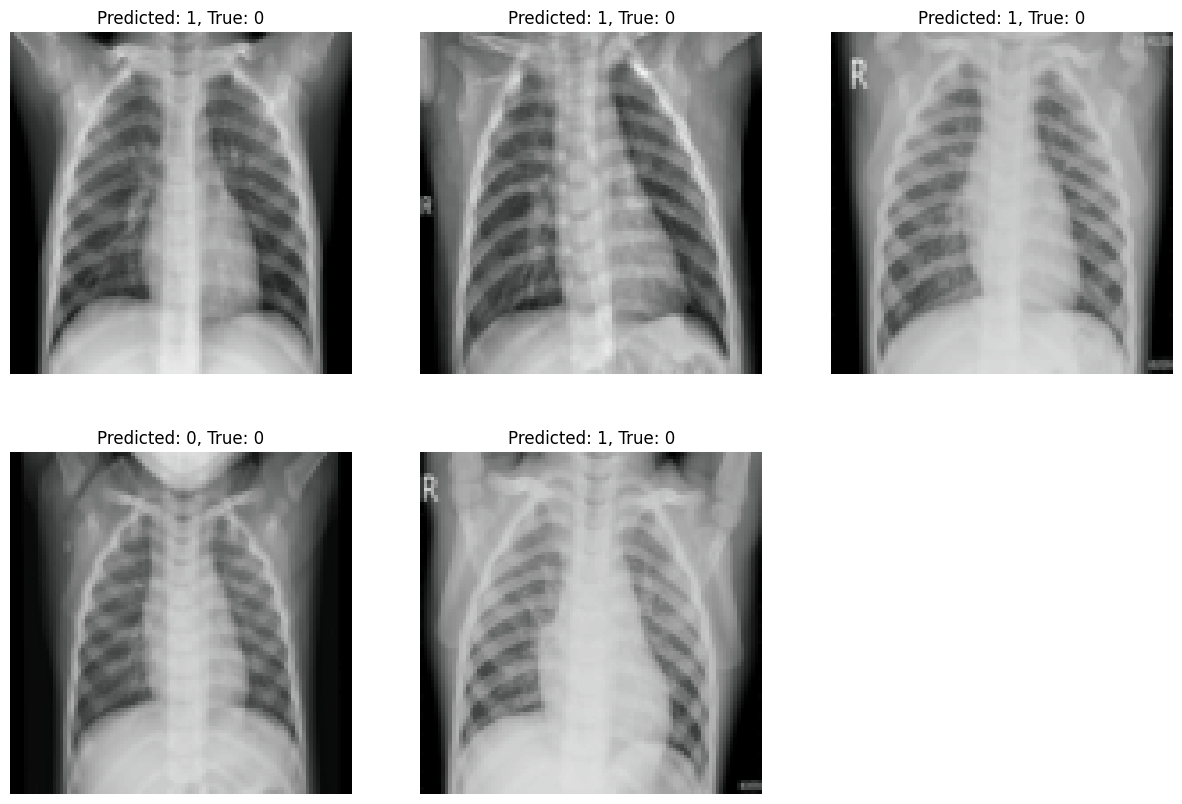

In [ ]:
# Uncomment to visualize predictions
visualize_predictions(model, test_loader)